In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage.measure import label
f = 'NOMADS_resample.tif'

In [2]:

def bounding_box(img):
    """
    Returns the z, y, x vectors that create a bounding box
    of a mask.
    """
    z = np.any(img, axis=(1, 2))
    y = np.any(img, axis=(0, 2))
    x = np.any(img, axis=(0, 1))

    zmin, zmax = np.where(z)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    xmin, xmax = np.where(x)[0][[0, -1]]

    return (zmin, zmax + 1), (ymin, ymax + 1), (xmin, xmax + 1)


def get_uniques(ar):
    """
    Returns an ordered numpy array of unique integers in an array.
    This runs about four times faster than numpy.unique().
    Parameters
    ----------
    ar : array_like
        Input array. This will be flattened.
    Returns
    -------
    uniques : ndarray
        The sorted unique values.
    """
    bins = np.zeros(np.max(ar) + 1, dtype=int)
    bins[ar.ravel()] = 1
    uniques = np.nonzero(bins)[0]

    return uniques


def get_unique_overlap(foreground, background, i):
    '''
    Calculates the number of unique background labels in the foreground at i
    Does not count background label of 0
    '''
    z, y, x = bounding_box(foreground == i)

    foreground = foreground[z[0]:z[1], y[0]:y[1], x[0]:x[1]]
    background = background[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

    overlaps = np.multiply((foreground == i), background)
    uniques = get_uniques(overlaps)

    num_unique = len(uniques)

    #0 is background label
    #should not count as a detection if
    #the prediction overlaps with the background
    if 0 in uniques:
        num_unique -= 1

    return num_unique


def compute_overlap_array(predictions, gt, compare_annotations=False):
    """
    When comparing two annotation volumes, set compare_annotations to True.
    """
    if not compare_annotations:
        predictions = label(predictions)
        prediction_uniques = get_uniques(predictions)[1:]
    elif compare_annotations:
        prediction_uniques = get_uniques(predictions)[1:]

    gt_uniques = get_uniques(gt)[1:]

    #first, look at how many unique predictions
    #overlap with a single gt synapse
    predictionPerGt = [get_unique_overlap(gt, predictions, i)
                       for i in gt_uniques]

    #next, look at how many unique synapses overlap
    #with a single synapse prediction
    gtPerPrediction = [get_unique_overlap(predictions, gt, i)
                       for i in prediction_uniques]

    return {'predictionPerGt': predictionPerGt,
            'gtPerPrediction': gtPerPrediction}

def graph_performance(absolute=False, *args, **kwds):
    """
    Graphs quantitative performance of an algorithm based on predictions
    per ground truth and ground truth per predictions.
    If keyword arguments are given, then the label names are taken from
    the keywords. If arguments are passed in with no keywords, then the
    labels are label_0, label_1, etc.
    Parameters
    ----------
    absolute : boolean, optional
        If True, the data will be presented in absolute frequencies instead of
        relative frequencies.
    args : Arguments
        Overlap dictionaries to plot. Since it is not possible to know what each
        overlap dictionary refers to, the data will be plotted with labels
        "label_0", "label_1", and so on.
    kwds : Keyword Arguments
        Overlap dictionaries to plot. Data will be plotted with the keyword labels.
    Examples
    --------
    >>> overlap_1 = compute_overlap_array(predictions_1, gt_1)
    >>> overlap_2 = compute_overlap_array(predictions_2, gt_2)
    >>> kwds = {'Label One': overlap_1, 'Label Two': overlap_2}
    >>> graph_performance(**kwds)
    """

    labeldict = kwds

    for i, val in enumerate(args):
        key = 'label_%d' % i
        if key in labeldict.keys():
            raise ValueError(
                "Cannot use un-named variables and keyword %s" % key)
        labeldict[key] = val

    labels = list(labeldict.keys())
    overlaps = [labeldict[label] for label in labels]

    #Global settings
    plt.rc(('xtick', 'ytick'), labelsize=14)
    plt.rc('axes', titlesize=16, labelsize=14)

    #Create fig and ax
    fig, ax = plt.subplots(1, 2, figsize=(10, 5.9), sharey=True)

    #Titles for figure and two subplots
    ax[0].set_title('Number of Predictions Per Synapse')
    ax[1].set_title('Number of Synapses Per Prediction')

    #Set xaxis tick labels
    ax[0].set_xticklabels(['False Negatives', 'Correct', 'Double Counted'])
    ax[1].set_xticklabels(['False Positives', 'Correct', 'Merged'])

    #Set yaxis label and range accordingly
    if not absolute:
        ax[0].set_ylabel("% of population")
        ax[0].set_ylim(0, 100)
    else:
        ax[0].set_ylabel("Total number")

    #Plot stuff
    for i, label in enumerate(labels):
        #Graphing settings
        width = 0.8 / len(labels)
        offset = np.arange(0, width * len(labels), width)

        for j, key in enumerate(['predictionPerGt', 'gtPerPrediction']):
            counts = np.bincount(overlaps[i][key])

            #Data validations
            if len(counts) == 2:
                counts = np.append(counts, [0])
            elif len(counts) > 3:
                counts = np.append(counts[0:2], [np.sum(counts[2:])])

            if not absolute:
                data = [x / sum(counts) * 100 for x in counts]
            else:
                data = counts

            ax[j].bar(np.arange(3) + offset[i], data,
                      width=width, align='edge', label=label)
            ax[j].set(xticks=np.arange(3) + .4)

    #Finishing touches
    fig.tight_layout()
    plt.legend()

    return fig

In [3]:
a =  tiff.imread(f)

In [4]:
a.shape

(49, 4288, 4160)

In [5]:
base = "collman_M247514_Rorb_1_Site3Align2_EM_m247514_Site3Annotation_MN_global_x5961-10121_y4891-9179_z"

In [6]:
b = [base + str(i).zfill(2) + ".tif" for i in range(49)]

In [7]:
ai = [tiff.imread(b[i]) for i in range(len(b))]
tmp = np.stack(ai)
ai  = tmp.astype(np.int)
len(ai)

49

In [8]:
aReduced =  a[:, slice(133, 4155), slice(133, 4027)]
aiReduced = ai[:, slice(133, 4155), slice(133, 4027)]

In [9]:
out_pred = compute_overlap_array(a, ai)

In [10]:
out_predReduced = compute_overlap_array(aReduced, aiReduced)

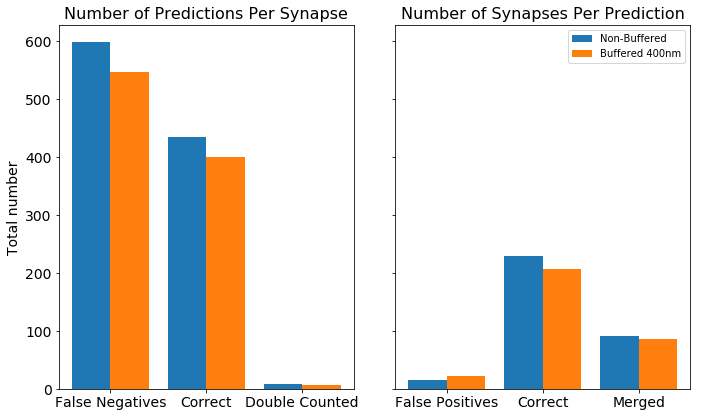

In [11]:
kwds = {'Non-Buffered': out_pred, 'Buffered 400nm': out_predReduced}
graph_performance(True, **kwds)

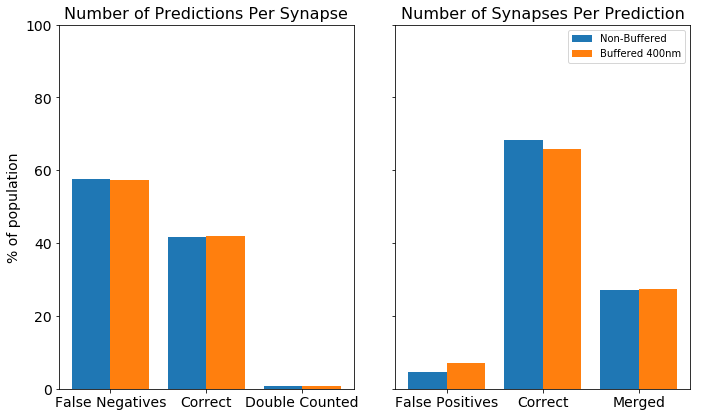

In [12]:
graph_performance(False, **kwds)

In [ ]:
plt.imshow(ai[0][slice(500, 1000), slice(500, 1000)])
plt.show()

In [ ]:
plt.imshow(a[1,:,:])
plt.show()

In [ ]:
tmp = label(a)

In [ ]:
plt.imshow(tmp[14, :, :])
plt.show()